# Import required libraries

In [3]:

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Set global plotting style

In [4]:

sns.set(style="whitegrid")


# Load datasets

In [9]:

customers = pd.read_csv("C:/Users/PREMKUMAR BAJARU\Desktop/eCommerce-Transactions-Analysis/ZeoTape assignment/Data/Customers.csv")
products = pd.read_csv("C:/Users/PREMKUMAR BAJARU\Desktop/eCommerce-Transactions-Analysis/ZeoTape assignment/Data/Products.csv")
transactions = pd.read_csv("C:/Users/PREMKUMAR BAJARU\Desktop/eCommerce-Transactions-Analysis/ZeoTape assignment/Data/Transactions.csv")

In [10]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [11]:
products.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [12]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


# Task 1: Exploratory Data Analysis (EDA)


--- EDA Summary ---


Customers Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Customers Missing Values:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Products Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None

P

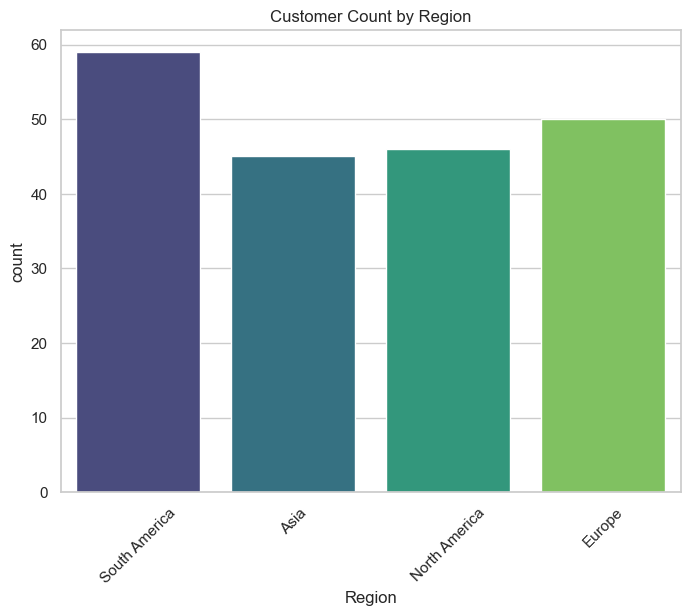

c:\Users\KIIT\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


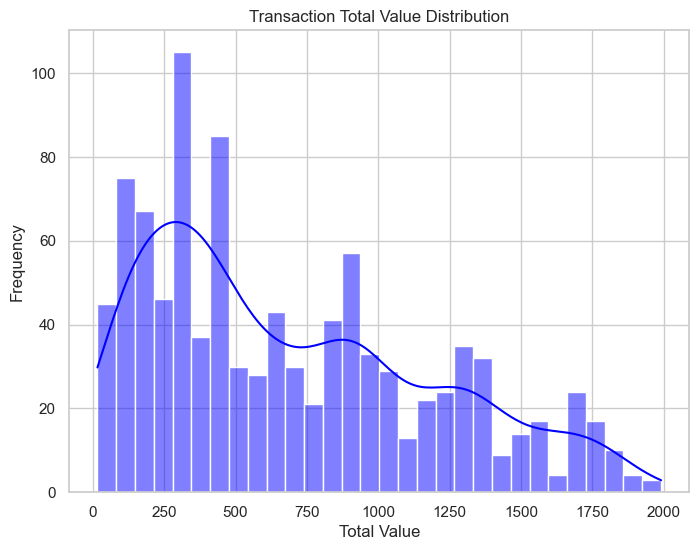

In [13]:
def perform_eda():
    print("\n--- EDA Summary ---\n")

    # Display basic info and check missing values
    for df, name in zip([customers, products, transactions], ["Customers", "Products", "Transactions"]):
        print(f"\n{name} Dataset Info:\n")
        print(df.info())
        print(f"\n{name} Missing Values:\n{df.isnull().sum()}")

    # Summary statistics for transactions
    print("\nSummary Statistics for Transactions:\n", transactions.describe())

    # Visualizations
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Region', data=customers, palette="viridis")
    plt.title('Customer Count by Region')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.histplot(transactions['TotalValue'], bins=30, kde=True, color="blue")
    plt.title('Transaction Total Value Distribution')
    plt.xlabel('Total Value')
    plt.ylabel('Frequency')
    plt.show()

perform_eda()

# Task 2: Lookalike Model

In [14]:
def lookalike_model():
    print("\n--- Building Lookalike Model ---\n")

    # Prepare data for similarity
    merged_data = pd.merge(transactions, customers, on='CustomerID')
    merged_data = pd.merge(merged_data, products, on='ProductID')

    pivot_table = merged_data.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', aggfunc='sum', fill_value=0)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pivot_table)

    # PCA for dimensionality reduction
    pca = PCA(n_components=0.95, random_state=42)
    reduced_data = pca.fit_transform(scaled_data)

    # Nearest Neighbors
    model = NearestNeighbors(n_neighbors=4, metric='cosine')
    model.fit(reduced_data)

    lookalike_results = {}
    for idx, customer_id in enumerate(pivot_table.index[:20]):
        distances, indices = model.kneighbors([reduced_data[idx]])
        similar_customers = [
            (pivot_table.index[indices[0][j]], round(1 - distances[0][j], 4))
            for j in range(1, len(indices[0]))  # Skip the first index as it's the customer itself
        ]
        lookalike_results[customer_id] = similar_customers[:3]

    # Save results to CSV
    flattened_results = [
        {
            "CustomerID": customer_id,
            "SimilarCustomerID": similar[0],
            "SimilarityScore": similar[1]
        }
        for customer_id, similars in lookalike_results.items()
        for similar in similars
    ]
    result_df = pd.DataFrame(flattened_results)
    result_df.to_csv("FirstName_LastName_Lookalike.csv", index=False)
    print("Lookalike results saved to CSV.")

lookalike_model()


--- Building Lookalike Model ---

Lookalike results saved to CSV.


# Task 3: Customer Segmentation / Clustering


--- Performing Customer Segmentation ---



c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows wi

Optimal Number of Clusters: 2
Davies-Bouldin Scores: [0.6298644531019864, 0.6790773231366432, 0.7102764046737506, 0.7529350579420508, 0.8164295471714538, 0.7790991322899362, 0.8993608517663891, 0.8232396439456046, 0.8554143386495809]
Silhouette Scores: [0.5468050856155675, 0.46110403768392266, 0.45391090877699, 0.4315131216122974, 0.3982228166826938, 0.4067360036270199, 0.3687188420888189, 0.36018293105042104, 0.35816886716338453]
Final Davies-Bouldin Index: 0.6299


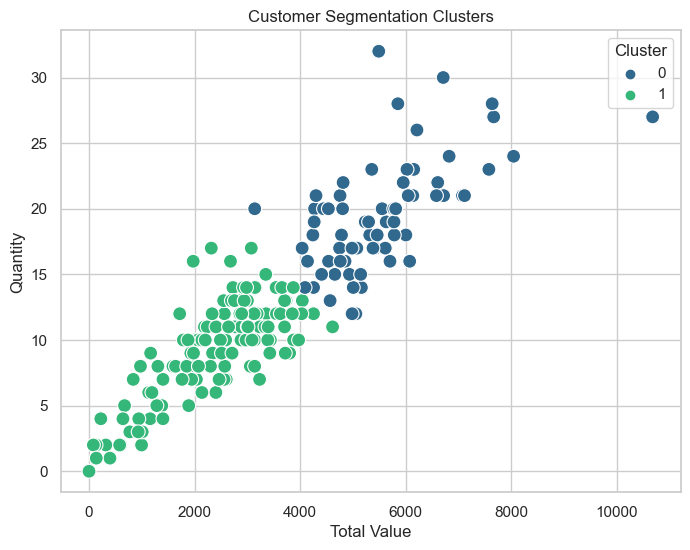

Clustering results saved to CSV.


In [15]:
def customer_segmentation():
    print("\n--- Performing Customer Segmentation ---\n")

    # Merge and preprocess data
    customer_transactions = transactions.groupby('CustomerID').agg({'TotalValue': 'sum', 'Quantity': 'sum'}).reset_index()
    customer_data = pd.merge(customers, customer_transactions, on='CustomerID', how='left').fillna(0)

    features = ['TotalValue', 'Quantity']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(customer_data[features])

    # Evaluate different cluster sizes for optimal clustering
    db_indices = []
    silhouette_scores = []
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_features)
        db_indices.append(davies_bouldin_score(scaled_features, labels))
        silhouette_scores.append(silhouette_score(scaled_features, labels))

    optimal_clusters = db_indices.index(min(db_indices)) + 2
    print(f"Optimal Number of Clusters: {optimal_clusters}")
    print(f"Davies-Bouldin Scores: {db_indices}")
    print(f"Silhouette Scores: {silhouette_scores}")

    # KMeans Clustering
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

    # Calculate final DB Index
    final_db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
    print(f"Final Davies-Bouldin Index: {final_db_index:.4f}")

    # Visualize clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=customer_data['TotalValue'], 
        y=customer_data['Quantity'], 
        hue=customer_data['Cluster'], 
        palette="viridis",
        s=100
    )
    plt.xlabel('Total Value')
    plt.ylabel('Quantity')
    plt.title('Customer Segmentation Clusters')
    plt.legend(title='Cluster')
    plt.show()

    # Save report
    customer_data[['CustomerID', 'Cluster']].to_csv("FirstName_LastName_Clustering.csv", index=False)
    print("Clustering results saved to CSV.")

customer_segmentation()


# Thank You

# Done by : PREMKUMAR BAJARU
> Phone : 9030590462<br>
>Email : premkumarbajaru@gmail.com </h3>